# Polyjuice first try

In [ ]:
from transformers import AutoTokenizer, AutoModelWithLMHead
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM

model_path = "uw-hai/polyjuice"
generator = pipeline("text-generation",
    model=AutoModelForCausalLM.from_pretrained(model_path),
    tokenizer=AutoTokenizer.from_pretrained(model_path),
    framework="pt", device=-1)

In [30]:
from datasets import load_dataset
dataset = load_dataset("snli")
dataset['train'][2]

Reusing dataset snli (/Users/afra/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b)


  0%|          | 0/3 [00:00<?, ?it/s]

{'premise': 'A person on a horse jumps over a broken down airplane.',
 'hypothesis': 'A person is outdoors, on a horse.',
 'label': 0}

In [18]:
original_premise = dataset['train'][2]['premise']
hypothesis = dataset['train'][2]['hypothesis']
original_label = dataset['train'][2]['label']

In [56]:
prompt_text = "{} {} <|perturb|> [insert]".format(original_premise, hypothesis)
# prompt_text = "A dog is embraced by the woman. <|perturb|> [negation] A dog is [BLANK] the woman."
generator(prompt_text, num_beams=1, num_return_sequences=1)[0]["generated_text"]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'A person on a horse jumps over a broken down airplane. A person is outdoors, on a horse. <|perturb|> [insert] [BLANK] [SEP] A person on a pony jumps over a broken down dirt ground'

# Simple heuristic for blank position

In [1]:
import benepar, spacy


In [2]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [69]:
import nltk
benepar.download('benepar_en3')
  

[nltk_data] Downloading package benepar_en3 to
[nltk_data]     /Users/afra/nltk_data...
[nltk_data]   Unzipping models/benepar_en3.zip.


True

In [3]:
nlp.add_pipe('benepar', config={'model': 'benepar_en3'})
doc = nlp('The time for action is now. It is never too late to do something.')
sent = list(doc.sents)[0]

/Users/afra/University/IML/Counterfactuals-xai-iml22/.venv/lib/python3.8/site-packages/torch/distributions/distribution.py:44: UserWarning: <class 'torch_struct.distributions.TreeCRF'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


In [6]:
!pip install svgling

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     |████████████████████████████████| 66 kB 3.2 MB/s eta 0:00:011
You should consider upgrading via the '/Users/afra/University/IML/Counterfactuals-xai-iml22/.venv/bin/python -m pip install --upgrade pip' command.


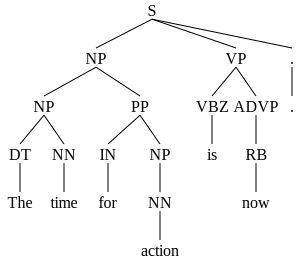

In [11]:
from nltk import Tree
tree = Tree.fromstring(sent._.parse_string)
tree

In [14]:
from nltk import ParentedTree
def add_indices_to_terminals(treestring):
    tree = ParentedTree.fromstring(treestring)
    for idx, _ in enumerate(tree.leaves()):
        tree_location = tree.leaf_treeposition(idx)
        non_terminal = tree[tree_location[:-1]]
        non_terminal[0] = non_terminal[0] + "_" + str(idx)
    return str(tree)

In [19]:
tree = Tree.fromstring(tree_str)

In [30]:
tree[0][0][0][0].split("_")[-1]

'0'

In [39]:
len(tree[0])

2

In [48]:
def find_constituent(node, candidate_list):
    print(node)
    if len(node) == 1 and type(node[0]) == str:
        idx = int(node[0].split("_")[-1])
        return idx, idx
    
    first_idx = last_idx = 0
    for i in range(len(node)):
        idx = find_constituent(node[i], candidate_list)
        if i == 0:
            first_idx = idx[0]
        else:
            last_idx = idx[1]
    candidate_list.append((first_idx, last_idx))
    return first_idx, last_idx

In [51]:
candidate_list = []
find_constituent(tree, [])

(S
  (NP (NP (DT The_0) (NN time_1)) (PP (IN for_2) (NP (NN action_3))))
  (VP (VBZ is_4) (ADVP (RB now_5)))
  (. ._6))
(NP (NP (DT The_0) (NN time_1)) (PP (IN for_2) (NP (NN action_3))))
(NP (DT The_0) (NN time_1))
(DT The_0)
(NN time_1)
(PP (IN for_2) (NP (NN action_3)))
(IN for_2)
(NP (NN action_3))
(NN action_3)
(VP (VBZ is_4) (ADVP (RB now_5)))
(VBZ is_4)
(ADVP (RB now_5))
(RB now_5)
(. ._6)


(0, 6)

In [52]:
candidate_list

[]

In [ ]:
def find_blank_index(sentence):
    doc = nlp(sentence)
    sent = list(doc.sents)[0]
    tree_str = add_indices_to_terminals(sent._.parse_string)
    tree = Tree.fromstring(tree_str)
    
    
    
    